## Predict fluctuations in currency quote

Let's try build model with help of [Prophet](https://facebookincubator.github.io/prophet/) to prеditi fluctuations in currency quotes. For current example I took currency pair UAH/USD for date range 2012-2017.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error

from fbprophet import Prophet

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    fig = {'data': data, 'layout': {'title': title}}
    iplot(fig, show_link=False)

### Getting data

In [154]:
# you can download any date range from the yahoo
# trend_df = web.DataReader('UAH=X', 'yahoo', datetime(2012, 1, 1))

trend_df = pd.read_csv('data/uah_usd_12_17.csv')

In [158]:
# set index for a future manipulation with dates
trend_df.Date = trend_df.Date.apply(lambda d: pd.to_datetime(d))
trend_df.set_index('Date', inplace=True);

In [156]:
trend_df.shape

(1395, 7)

In [78]:
trend_df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1395.000000,1395.000000,1395.000000,1395.000000,1395.0,1395.000000
mean,15.708088,15.801296,15.640306,15.704601,0.0,15.704601
std,7.662312,7.743719,7.603184,7.662233,0.0,7.662233
min,7.867000,7.893100,7.867000,7.858500,0.0,7.858500
25%,8.037400,8.040300,8.035450,8.038250,0.0,8.038250
50%,12.673000,12.720000,12.638000,12.675000,0.0,12.675000
75%,24.450000,24.526000,24.389000,24.452500,0.0,24.452500
max,33.901000,33.901000,27.671000,33.499000,0.0,33.499000


In [79]:
trend_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1395 entries, 2012-01-02 to 2017-05-09
Data columns (total 6 columns):
Open         1395 non-null float64
High         1395 non-null float64
Low          1395 non-null float64
Close        1395 non-null float64
Volume       1395 non-null int64
Adj Close    1395 non-null float64
dtypes: float64(5), int64(1)
memory usage: 76.3 KB


In [162]:
plotly_df(trend_df[['Open', 'High', 'Low', 'Adj Close']], title='UAH/USD 2012-2017')

### Data cleaning

#### Get rid from outliers

According to documentation of Prophet, the best way to handle outliers is to remove them - Prophet has no problem with missing data.

In [164]:
trend_df.loc[
    (trend_df.index > datetime(2014, 2, 20)) & 
    (trend_df.index < datetime(2014, 3, 10)) & 
    (trend_df['Adj Close'] > 9.5), 
    'Adj Close'
] = None

In [165]:
trend_df.loc[
    (trend_df.index > datetime(2014, 3, 20)) & 
    (trend_df.index < datetime(2014, 4, 30)) & 
    (trend_df['Adj Close'] > 11.5), 
    'Adj Close'
] = None

In [166]:
trend_df.loc[
    (trend_df.index > datetime(2014, 9, 18)) & 
    (trend_df.index < datetime(2014, 10, 10)) & 
    (trend_df['Adj Close'] > 13), 
    'Adj Close'
] = None

In [167]:
trend_df.loc[
    (trend_df.index > datetime(2015, 2, 1)) & 
    (trend_df.index < datetime(2015, 2, 10)) & 
    (trend_df['Adj Close'] > 20), 
    'Adj Close'
] = None

In [168]:
trend_df.loc[
    (trend_df.index > datetime(2015, 2, 1)) & 
    (trend_df.index < datetime(2015, 3, 20)) & 
    (trend_df['Adj Close'] > 24), 
    'Adj Close'
] = None

In [169]:
plotly_df(trend_df[['Adj Close']], title='Cleaned data')

### Add holidays

Documentation about [holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html)

In [87]:
holidays = pd.DataFrame({
  'holiday': 'national',
  'ds': pd.to_datetime([
      '2012-01-01', '2012-01-06', '2013-01-01', '2013-01-06', '2014-01-01', '2014-01-06', 
      '2015-01-01', '2015-01-06', '2016-01-01', '2016-01-06', '2017-01-01', '2017-01-06',
      '2012-03-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
      '2012-03-08', '2013-03-08', '2014-03-08', '2015-03-08', '2016-03-08', '2017-03-08',
      '2012-05-01', '2013-05-01', '2014-05-01', '2015-05-01', '2016-05-01', '2017-05-01',
      '2012-05-02', '2013-05-02', '2014-05-02', '2015-05-02', '2016-05-02', '2017-05-02',
      '2012-05-09', '2013-05-09', '2014-05-09', '2015-05-09', '2016-05-09', '2017-05-09',
  ]),
  'lower_window': 0,
  'upper_window': 1,
})

### Cross validation

For cross validation let's take last 60 days

In [ ]:
predictions = 60

train_df = trend_df[:-predictions]
train_df.reset_index(inplace=True)

train_df.rename(columns={'Date': 'ds', 'Adj Close': 'y', 'High': 'yhat_upper', 'Low': 'yhat_lower'}, inplace=True)

In [89]:
train_df[['ds', 'y', 'yhat_lower', 'yhat_upper']].tail()

,ds,y,yhat_lower,yhat_upper
1330,2017-02-08,26.695,26.648,26.910
1331,2017-02-09,26.537,26.558,27.035
1332,2017-02-10,26.811,26.807,27.210
1333,2017-02-13,26.944,26.977,27.380
1334,2017-02-14,27.108,26.894,27.260


### Build a model

In [173]:
%%time

m = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=18)
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions)

forecast_test = m.predict(future)

CPU times: user 5.81 s, sys: 4.13 s, total: 9.94 s
Wall time: 5.51 s


In [174]:
test_df = forecast_test[-predictions:].set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]

In [175]:
index_list = trend_df[
    (trend_df.index >= test_df.index.min()) & (trend_df.index <= test_df.index.max())
].index.tolist()

In [176]:
# check influence of the holidays
forecast_test[(forecast_test['national']).abs() > 0][['ds', 'national']][-10:]

,ds,national
1089,2016-03-08,-0.043957
1090,2016-03-09,0.119246
1128,2016-05-02,0.075289
1129,2016-05-03,0.119246
1133,2016-05-09,-0.043957
1134,2016-05-10,0.119246
1303,2017-01-02,0.119246
1307,2017-01-06,-0.043957
1356,2017-03-08,-0.043957
1357,2017-03-09,0.119246


### Evaluate model

For evaluation let's take [Mean squared error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and [Mean absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

In [94]:
print('Mean squared error: {}'.format(
    mean_squared_error(
        trend_df[trend_df.index.isin(index_list)]['Adj Close'].values, 
        test_df[test_df.index.isin(index_list)]['yhat'].values
    )
))

Mean squared error: 1.0407109491747677


In [95]:
print('Mean avsolute error: {}'.format(
    mean_absolute_error(
        trend_df[trend_df.index.isin(index_list)]['Adj Close'].values, 
        test_df[test_df.index.isin(index_list)]['yhat'].values
    )
))

Mean avsolute error: 0.9977340371358951


### Visualizate forecast

Prophet can plot the forecast dataframe. Also you can see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

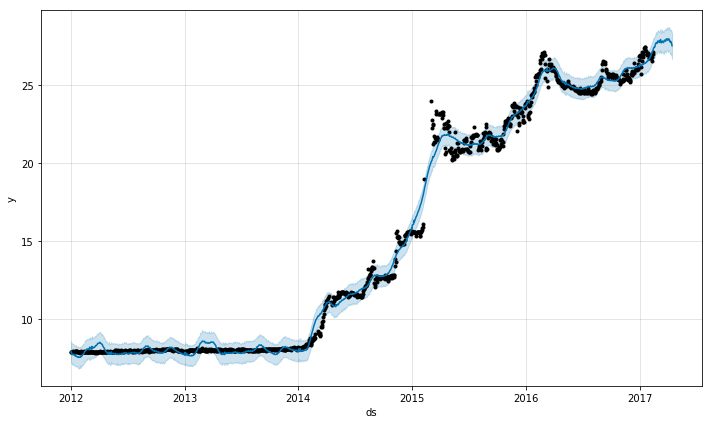

In [177]:
m.plot(forecast_test);

###  Visualizate the forecast components

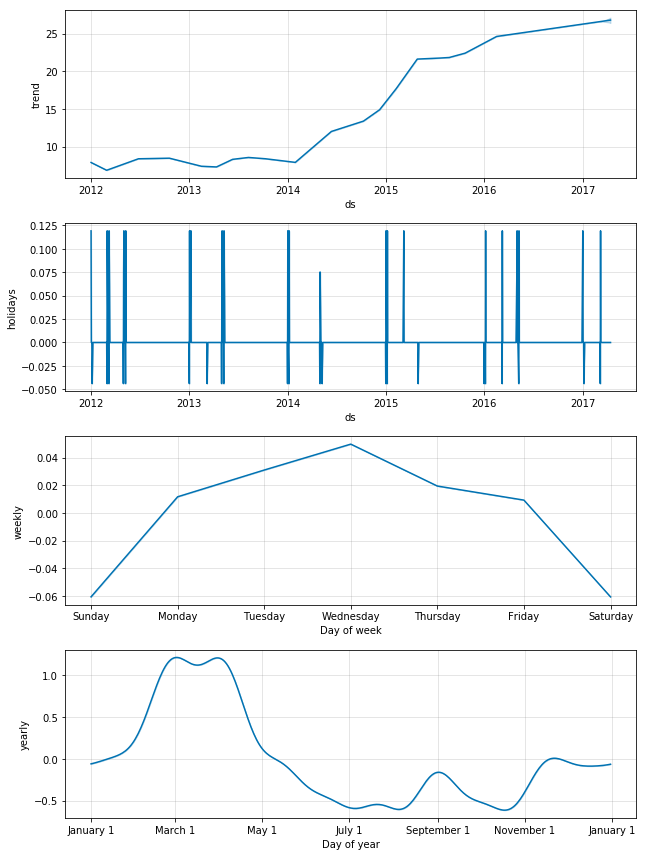

In [178]:
m.plot_components(forecast_test);

### Build forecast for the next 4 months

In [182]:
predict_df = trend_df.copy()
predict_df.reset_index(inplace=True)

predict_df.rename(columns={'Date': 'ds', 'Adj Close': 'y', 'High': 'yhat_upper', 'Low': 'yhat_lower'}, inplace=True)

In [235]:
%%time

m = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=18)
m.fit(predict_df);

future = m.make_future_dataframe(periods=120)

forecast = m.predict(future)

CPU times: user 5.43 s, sys: 3.73 s, total: 9.16 s
Wall time: 5.73 s


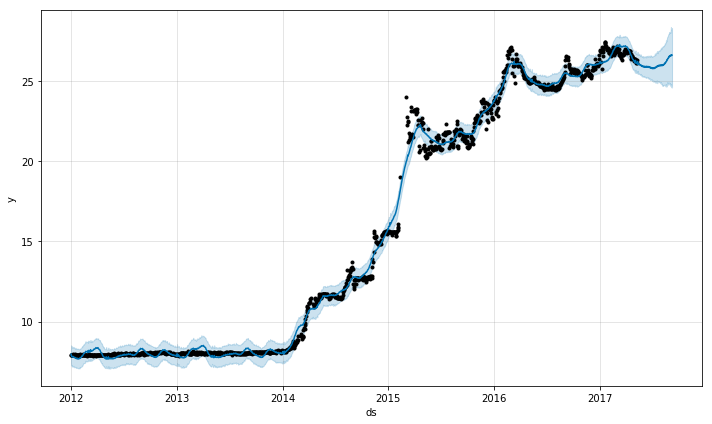

In [236]:
m.plot(forecast);

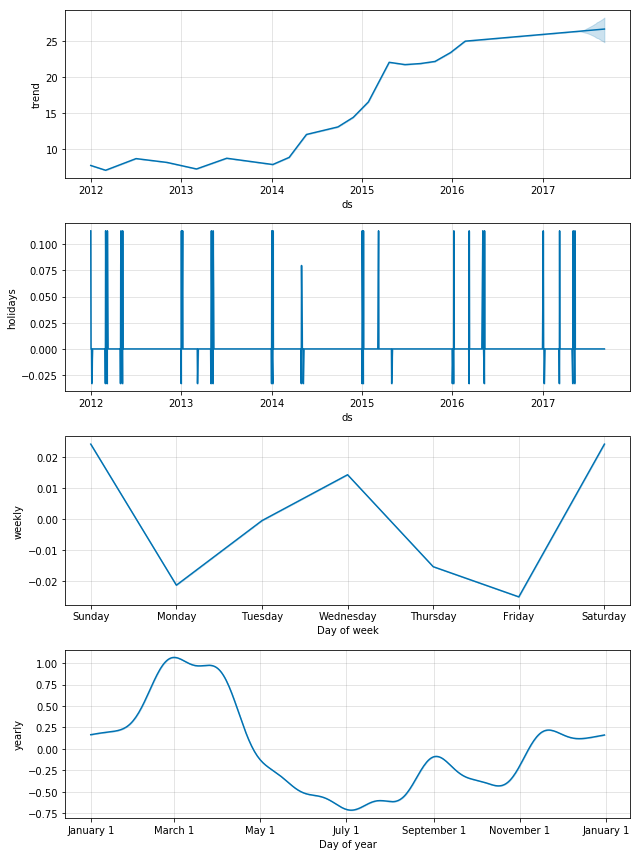

In [237]:
m.plot_components(forecast);

### Visualizate the forecast in the details

In [238]:
forecast[['ds', 'yhat_upper', 'yhat', 'yhat_lower']].tail()

,ds,yhat_upper,yhat,yhat_lower
1510,2017-09-02,28.347494,26.605248,24.796040
1511,2017-09-03,28.222876,26.609200,24.768681
1512,2017-09-04,28.158643,26.564806,24.581673
1513,2017-09-05,28.269038,26.584262,24.718163
1514,2017-09-06,28.284613,26.595271,24.580365


In [239]:
forecast_df = forecast[['ds', 'yhat_upper', 'yhat', 'yhat_lower']][-180:]

forecast_df.set_index('ds', inplace=True)
forecast_df.rename(
    columns={'yhat_upper': 'forecast_upper', 'yhat': 'forecast', 'yhat_lower': 'forecast_lower'}, 
    inplace=True
)

plotly_df(forecast_df, title='The forecast in the details')